Prior to this, the raw data has been parsed through the data_clean notebook. In that notebook, irregularities in the dataset have been removed which were consequences of the scraping, and 3 columns have been added, namely Province, which was derived from the Location, and using a dataset of all towns in the Netherlands, the province was found, Make, which was derived from the title and a dataset of all well-known car makes, and models, which was also derived from the title in a similar manner.

In this file, we will further explore the data, remove outliers, and try to learn as much about the data as possible.

Let's import the needed libraries and change the settings

In [3]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Reading in the main cleaned dataframe. The body column was very sparse, so we discarded it altogether.

In [4]:
df = pd.read_csv('data/cleaned/data_NoNaN.csv')
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,fiat,doblo,18500,2005.0,199313.0,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,ranger,22600,2017.0,107195.0,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,roadline,6950,2008.0,47108.0,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,audi,a3,11000,2013.0,201500.0,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
4,mercedes,sprinter,32900,2018.0,148939.0,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
...,...,...,...,...,...,...,...,...,...
10682,volkswagen,h1,21800,2018.0,148087.0,Heel Nederland,In every province,Action Lease,volkswagen transporter l1 h1 2018 €306 per maand
10683,renault,h1,24700,2021.0,67051.0,Heel Nederland,In every province,Action Lease,renault trafic l2 h1 2021 €344 per maand
10684,renault,h1,41800,2022.0,60.0,Heel Nederland,In every province,Action Lease,renault master l3 h1 2022 €635 per maand
10685,volkswagen,h2,17600,2017.0,198504.0,Heel Nederland,In every province,Action Lease,volkswagen crafter l2 h2 2017 €247 per maand


Let's take a deeper look at the price column.

In [5]:
pd.options.display.float_format = '{:.2f}'.format
df["Price"].describe()

count     10687.00
mean      17838.60
std       79925.85
min           0.00
25%        3745.00
50%       12500.00
75%       21900.00
max     5749999.00
Name: Price, dtype: float64

As we can see below cars with a listing price more than 150k only make up 0.4% of all listings, there are also major outliers, like cars worth millions. For the sake of this project, we will discard these very high value cars.

In [6]:
count = 0
for price in df["Price"]:
    if price > 150000:
        count += 1
total = len(df["Price"])
percentage = count / total *100
number = len(df["Price"]) * (percentage /100)
percentage, number

(0.25264339852156825, 27.0)

Let's remove all cars below 500 and above 150000 euros.

In [7]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


df = remove_outliers(df, 'Price', lower=500, upper=150001)
df = df.drop_duplicates()

In [8]:
df["Price"].describe()


count     5884.00
mean     18304.25
std      16617.02
min        505.00
25%       6950.00
50%      14600.00
75%      23900.00
max     149999.00
Name: Price, dtype: float64

Let's continue by looking at the price distribuion of all car listings.

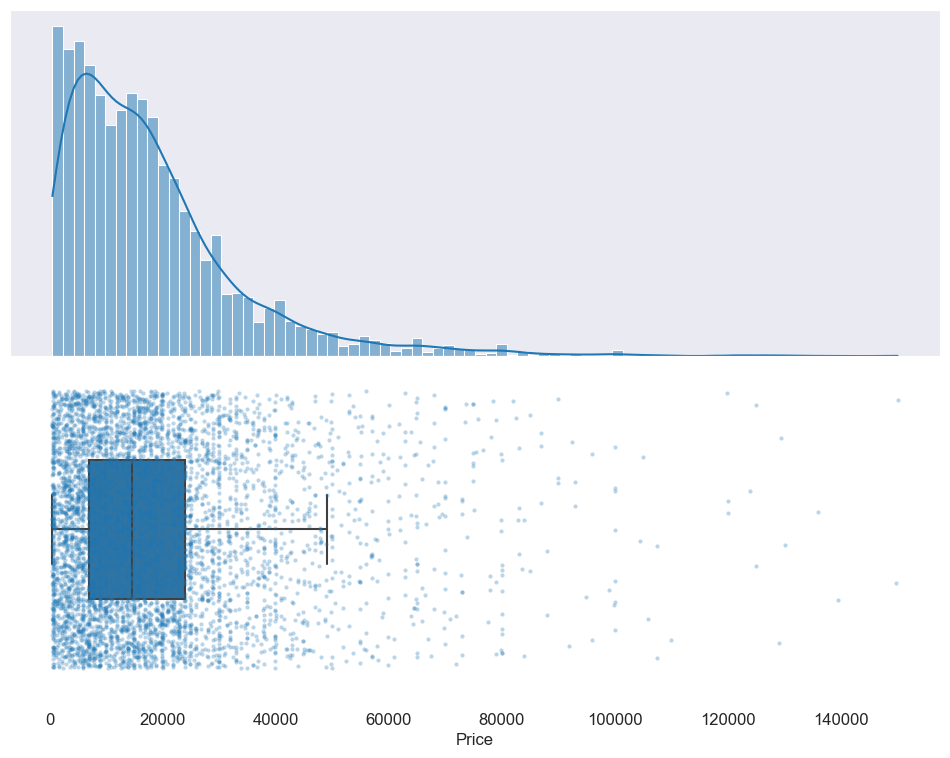

In [9]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

A potential outlier is the lowest price bin. In the collection of the data, we attempted to collect private and company listings seperately, marktplaats, however, did not do a very good job at that. We loaded the dataframe as a whole, meaning that we have both private and company listings in the dataframe. The low price  listings are very likely lease options, in which we are not interested.
Let's take a look.

In [10]:
df.loc[df.Price<1000]

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
31,peugeot,206,695,2005.00,232500.00,Hilversum,Noord-Holland,hydra,peugeot 206 quicksilver 1.4xs 16v bjr2005
195,porsche,cayenne,626,2012.00,162865.00,Veenendaal,Utrecht,ROS finance,porsche cayenne 4.8 gts | sport chrono | leder...
196,audi,q5,879,2020.00,32765.00,Veenendaal,Utrecht,ROS finance,audi q5 55 tfsi e 367pk 20inch 3x s-line lucht...
207,mercedes,200,621,2018.00,39945.00,Veenendaal,Utrecht,ROS finance,mercedes-benz a-klasse 200 *amg edition 1* pan...
364,peugeot,206,900,2001.00,149000.00,Rotterdam,Zuid-Holland,Hofman,peugeot 206 1.4 x-line 3d 2001 blauw
...,...,...,...,...,...,...,...,...,...
5758,volkswagen,fox,850,2006.00,220516.00,Amersfoort,Utrecht,Autohandel Honing,volkswagen fox 1.2 trendline
5774,mercedes,200,995,1997.00,353664.00,Amersfoort,Utrecht,Autohandel Honing,mercedes-benz clk-klasse coupé 200 sport
5844,mercedes,sprinter,763,2021.00,76857.00,Heel Nederland,In every province,Regeljelease.nl,mercedes-benz sprinter | 319
5854,mercedes,sprinter,796,2021.00,88534.00,Heel Nederland,In every province,Regeljelease.nl,mercedes-benz sprinter | 319 3.0 cdi v6 aut. l2h2


Looking at the table above shows that many of these cars are leases. This can be seen by the fact that the seller name and title contain the word lease, and also by the fact that cars under 1000 should mostly be low value old cars, not a 2012 4.8 Porsche Cayenne :).

We can try to remove lease options by first of all looking at which titles and sellers contain the words lease, finance, etc.
We could also make an argument for a correlation between Year and price, and decide that cars built after a certain year should not be less than 1000 euros.
Let's remove all listings in which the Title or the Seller contain the words lease or finance

In [11]:
df = df[~df.Title.str.contains('lease|finance', case=False)]
df = df[~df.Seller.str.contains('lease|finance', case=False)]
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,fiat,doblo,18500,2005.00,199313.00,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,ranger,22600,2017.00,107195.00,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,roadline,6950,2008.00,47108.00,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
4,mercedes,sprinter,32900,2018.00,148939.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
...,...,...,...,...,...,...,...,...,...
5859,volkswagen,transporter,28700,2017.00,145751.00,Barneveld,Gelderland,DUTCH Vans,volkswagen transporter personenbus 2.0tsi komb...
5867,volkswagen,h1,14600,2012.00,183398.00,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
5868,ford,transit,16700,2016.00,95864.00,Barneveld,Gelderland,DUTCH Vans,ford transit kipper 2.0tdci 3-zijdige kipper |...
5869,mercedes,h1,19300,2018.00,226713.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


That removed quite some rows! Let's look at the price distribution again.

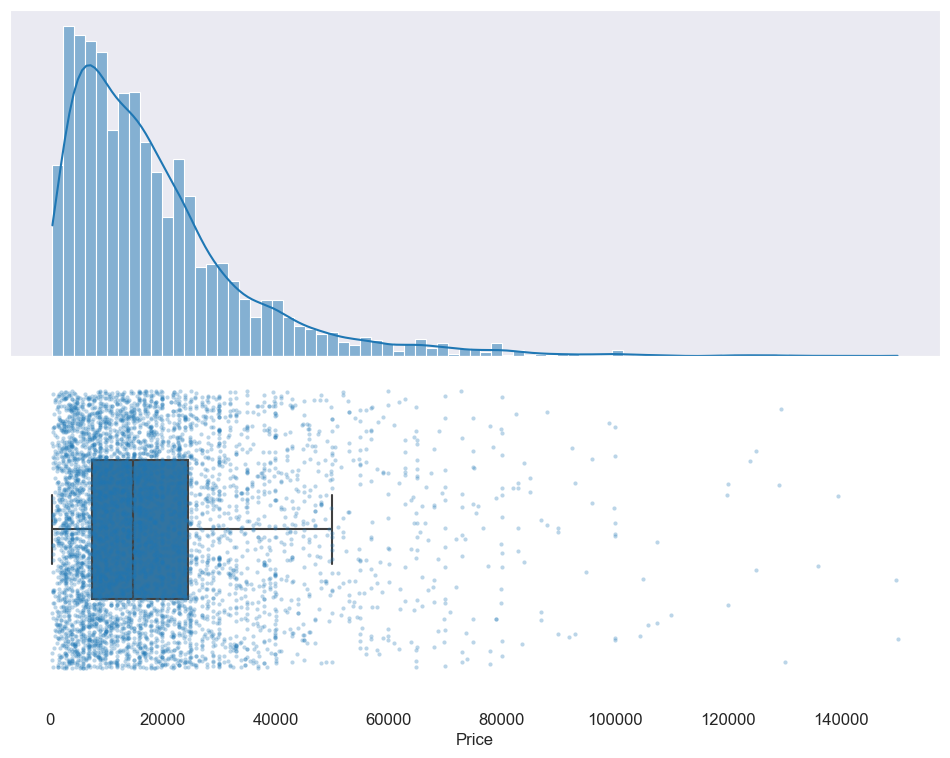

In [12]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"],
    orient='h',
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4,
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

This distribution makes much more sense. Now let's look at the distribution and listing prices of cars per province and how many cars are sold in each province.

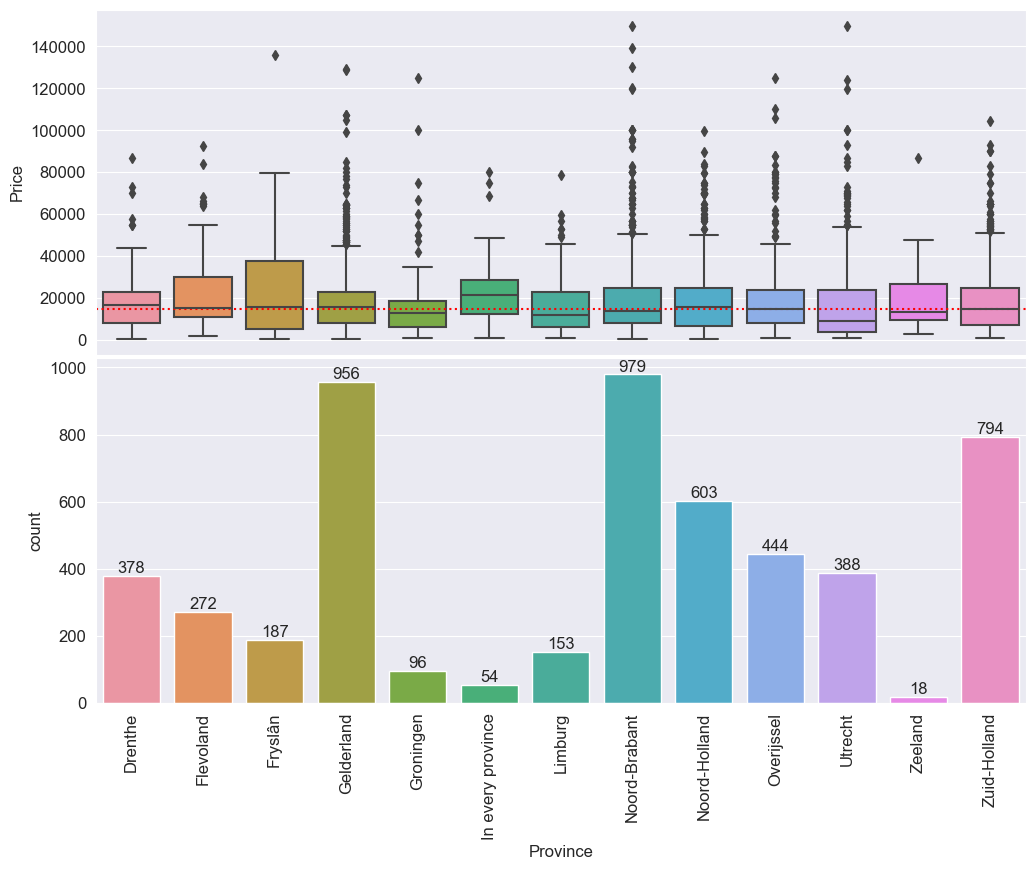

In [13]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Province',
    y='Price',
    data=df.sort_values('Province'),
    ax=axs[0]
)

sns.countplot(
    x='Province',
    data=df.sort_values('Province'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=df['Price'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

Now we can see that the mean listing price the cars are pretty close to each other for all of the provinces, but we do however see large difference in the amount of listings per province. But this is probably because most of these provinces are quite densely populated where much more people live as opposed to provinces such as Limburg, Zeeland, and Drenthe for example, with Gelderland being an outlier.
Now let's also look at the correlation between the Year the car was built and the Price.

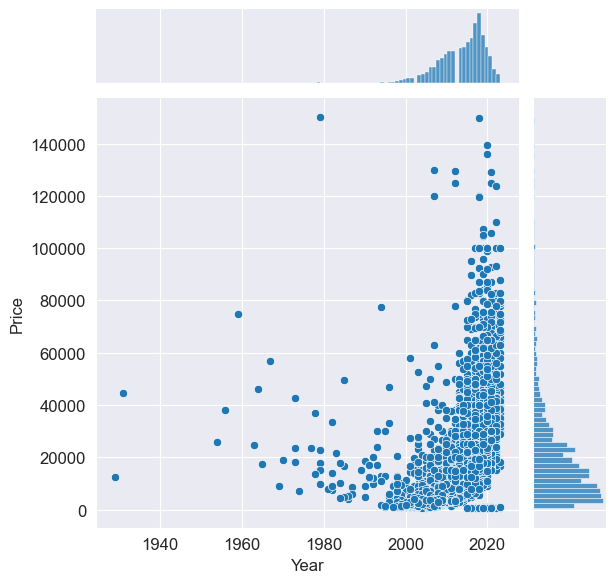

In [14]:
sns.jointplot(x='Year', y='Price', data=df)

We are removing cars before the year of 1995, as they cause much noise but are relatively sparse. They are noisy because some old cars have high value because of their old age, while othersare simply old and unreliable and therefore have the opposite effect. This is difficult to predict, and adds more noise that it does good.

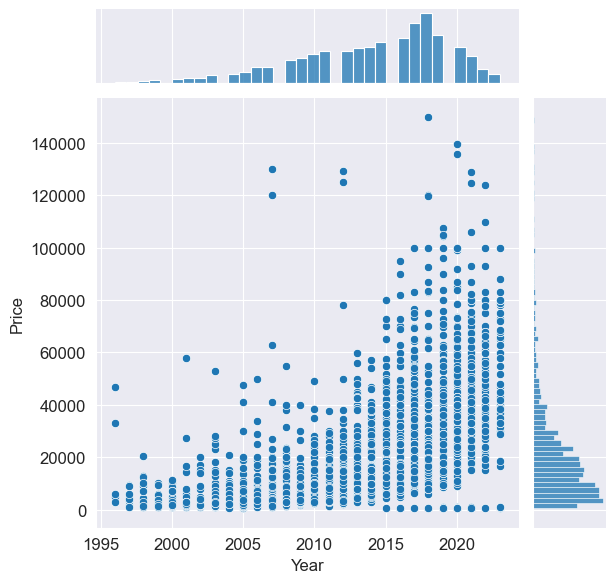

In [15]:
df = df[df.Year>1995]
sns.jointplot(x='Year', y='Price', data=df)

In this plot we can see that, from from 2005 to 2015, no cars are in the lowest price bracket. However, from 2015 to current, that bracket is populated again. Let's try removing all cars that are built from 2014 onwards, but are listed at a price lower than 1000 euros. These are very likely lease options.

In [16]:
df[(df.Year>=2013) & (df.Price<=1000)]

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
703,mercedes,sprinter,616,2021.00,48687.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 317cdi 170pk l3h2 euro6...
783,dodge,ram,899,2023.00,10.00,Nuland,Noord-Brabant,Millbrooks,"dodge ram 1500 5.7 v8 limited night, op voorra..."
1038,renault,m3,520,2023.00,150.00,Arnhem,Gelderland,Vissinga Automotive B.V.,renault master 10x bakwagen met 1000 kg laadkl...
1110,volkswagen,crafter,709,2022.00,34.00,Vaassen,Gelderland,Dethi Vans,volkswagen crafter 2.0tdi 140pk automaat l3h2 ...
1311,volkswagen,transporter,800,2020.00,64118.00,Leeuwarden,Fryslân,Bedrijfswagen centrum Leeuwarden,volkswagen transporter 2.0tdi 199pk 7-dsg dc b...
1313,mercedes,sprinter,687,2020.00,27157.00,Leeuwarden,Fryslân,Bedrijfswagen centrum Leeuwarden,mercedes-benz sprinter 319 3.0cdi v6 190pk aut...
1504,ford,transit,516,2021.00,38669.00,Vaassen,Gelderland,Dethi Vans,ford transit custom 2.0tdci lang raptor editio...
1576,mercedes,sprinter,551,2020.00,92866.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 316cdi 163pk l3h2 euro6...
1964,mercedes,sprinter,535,2019.00,135193.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 316cdi 163pk bakwagen +...
2397,dodge,ram,799,2023.00,1.00,Nuland,Noord-Brabant,Millbrooks,dodge ram 1500 nieuw 2023 met lpg 6 jaar fabri...


<Axes: xlabel='Year', ylabel='Price'>

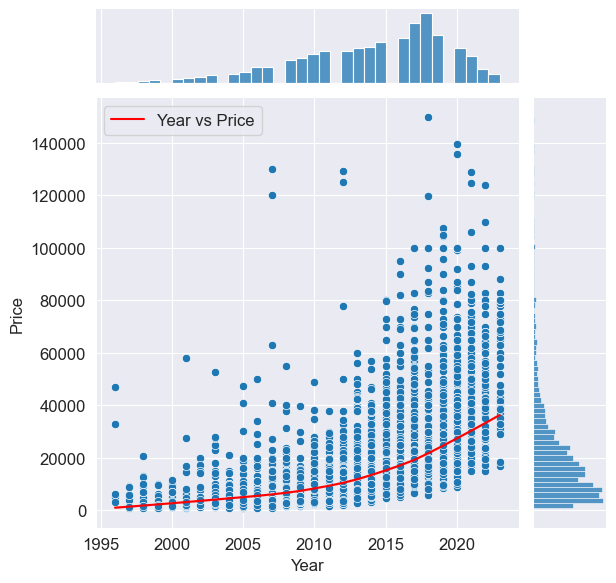

In [17]:
df = df[(df.Year<=2013) | (df.Price>=1000)]
sns.jointplot(x='Year', y='Price', data=df)
xobs = df.Year
yobs = df.Price
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Year vs Price', color='red')

Let's take a look at the correlation between the mileage of the car versus the price. We see a clear trend, where cars with less mileage are more expensive.

<Axes: xlabel='Price', ylabel='Ran'>

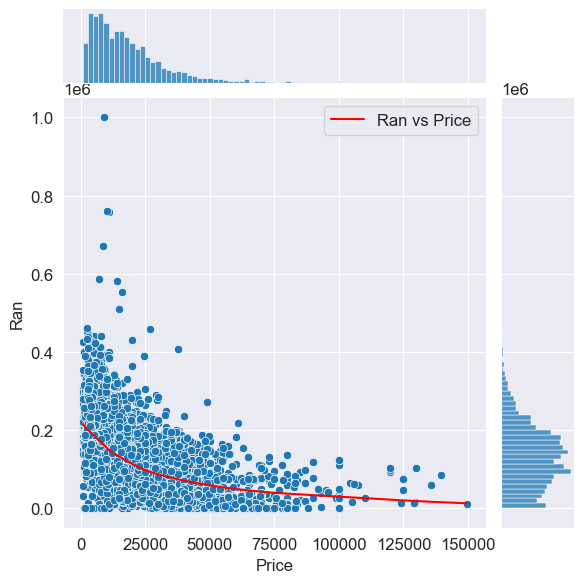

In [18]:
sns.jointplot(x='Price', y='Ran', data=df)
xobs = df.Price
yobs = df.Ran
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Ran vs Price', color='red')

Regressing based on year and mileage is interesting, however, a 2018 audi with 100.000 km is not the same price as a 2018 hyundai.
In the preprocessing, we have added makes and models of each vehicle. Let's see what information we can get from this!

In [19]:
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,fiat,doblo,18500,2005.00,199313.00,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,ranger,22600,2017.00,107195.00,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,roadline,6950,2008.00,47108.00,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
4,mercedes,sprinter,32900,2018.00,148939.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
...,...,...,...,...,...,...,...,...,...
5317,volkswagen,transporter,28700,2017.00,145751.00,Barneveld,Gelderland,DUTCH Vans,volkswagen transporter personenbus 2.0tsi komb...
5318,volkswagen,h1,14600,2012.00,183398.00,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
5319,ford,transit,16700,2016.00,95864.00,Barneveld,Gelderland,DUTCH Vans,ford transit kipper 2.0tdci 3-zijdige kipper |...
5320,mercedes,h1,19300,2018.00,226713.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


In [20]:
df_makes = df[['Make', 'Price', 'Ran', 'Year']].groupby(by='Make').agg({'Price':'mean', 'Year':'mean','Ran':'mean'})

In [21]:
df_makes['Make'] = df_makes.index
df_makes

,Price,Year,Ran,Make
Make,,,,
aixam,11261.23,2015.00,21418.08,aixam
alfa romeo,21704.67,2012.06,138241.67,alfa romeo
audi,27838.49,2014.42,136034.71,audi
bentley,46968.00,2003.20,106578.20,bentley
bmw,26233.93,2013.10,161522.59,bmw
cadillac,44950.00,2015.00,92100.00,cadillac
chevrolet,16708.50,2009.25,135620.62,chevrolet
chrysler,4286.25,2005.00,236297.25,chrysler
citroen,6832.37,2011.94,139375.85,citroen


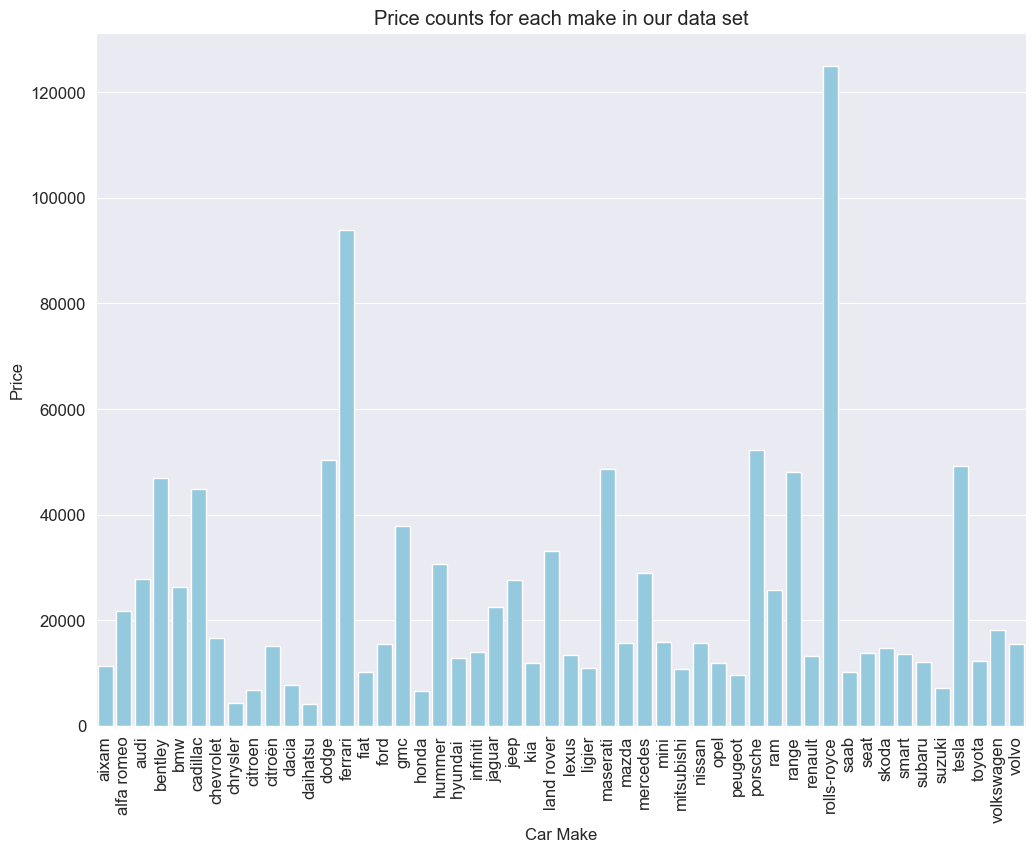

In [22]:
ax = sns.barplot(x='Make', y='Price', data=df_makes, color='skyblue')
# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Set the plot title and labels
plt.title("Price counts for each make in our data set")
plt.xlabel("Car Make")
plt.ylabel("Price")

# Show the plot
plt.show()

This plot does a good job of telling us that there is a lot of variation in the means of the prices of specific makes. For example we expect rolls-royces to be more expensive than a ford which is exactly what we see here.

In [23]:
model_counts = df['Model'].value_counts()
valid_models = model_counts[model_counts >= 5].index.tolist()
df = df[df['Model'].isin(valid_models)]

In [37]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    rmse = np.sqrt((sum((actual - predicted)**2)) / len(actual))
    return rmse

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define X and y
X = df[['Make', 'Model', 'Year', 'Ran']]
y = df['Price']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=60)

# Specify the model, alphas, and number of folds for CV
alphas = np.arange(0.1, 200.1, .1)
guidedmodel2 = lm.LassoCV(alphas=alphas, cv=5)

# Fit and predict
guidedmodel2.fit(X_train, y_train)
y_pred= guidedmodel2.predict(X_test)

print(f'The validation RMSE for this model with '
      f'alpha={round(float(guidedmodel2.alpha_), 2)} is '
      f'{round(rmse(y_test, y_pred))}.')
print('The R^2 score is ' + str(r2_score(y_test, y_pred)))




C:\Users\01din\PycharmProjects\pythonProject4\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306980569.3067627, tolerance: 89071516.49428993
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\01din\PycharmProjects\pythonProject4\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2382877596.0548706, tolerance: 89071516.49428993
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\01din\PycharmProjects\pythonProject4\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5060029513.956451, tolerance: 89071516.49428993
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\01din\

The validation RMSE for this model with alpha=1.6 is 8278.
The R^2 score is 0.7295720540262371


Now let's take a look at what effect different choices for the hyperparameter alpha ahve on the RMSE.

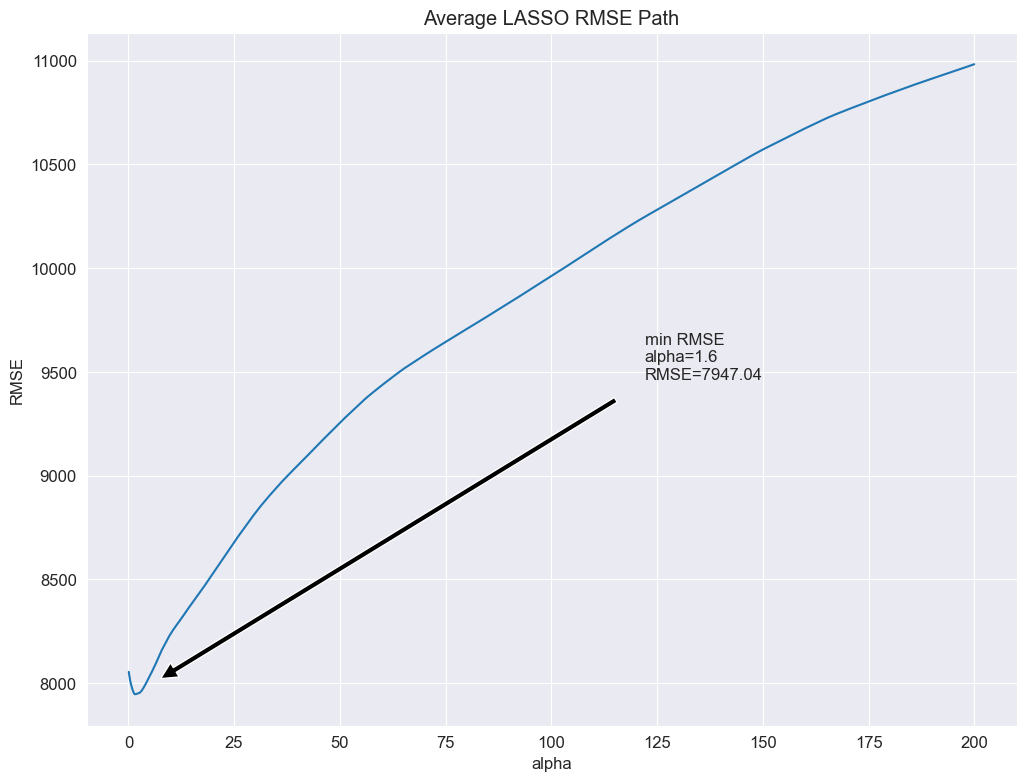

In [25]:
#plot alpha against RMSE.
plt.plot(guidedmodel2.alphas_, np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_)))
ax = plt.gca()
ax.set_title('Average LASSO RMSE Path')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')

# Find the minimum point and annotate it on the graph
min_idx = np.argmin(np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_)))
min_alpha = guidedmodel2.alphas_[min_idx]
min_rmse = np.sqrt(np.apply_along_axis(np.mean, 1, guidedmodel2.mse_path_))[min_idx]
ax.annotate(f'min RMSE\nalpha={round(min_alpha,2)}\nRMSE={round(min_rmse,2)}',
            xy=(min_alpha, min_rmse), xytext=(0.6, 0.5),
            textcoords='axes fraction', fontsize=12,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

The metrics look good! Let's plot the residuals to inspect the model visually.

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

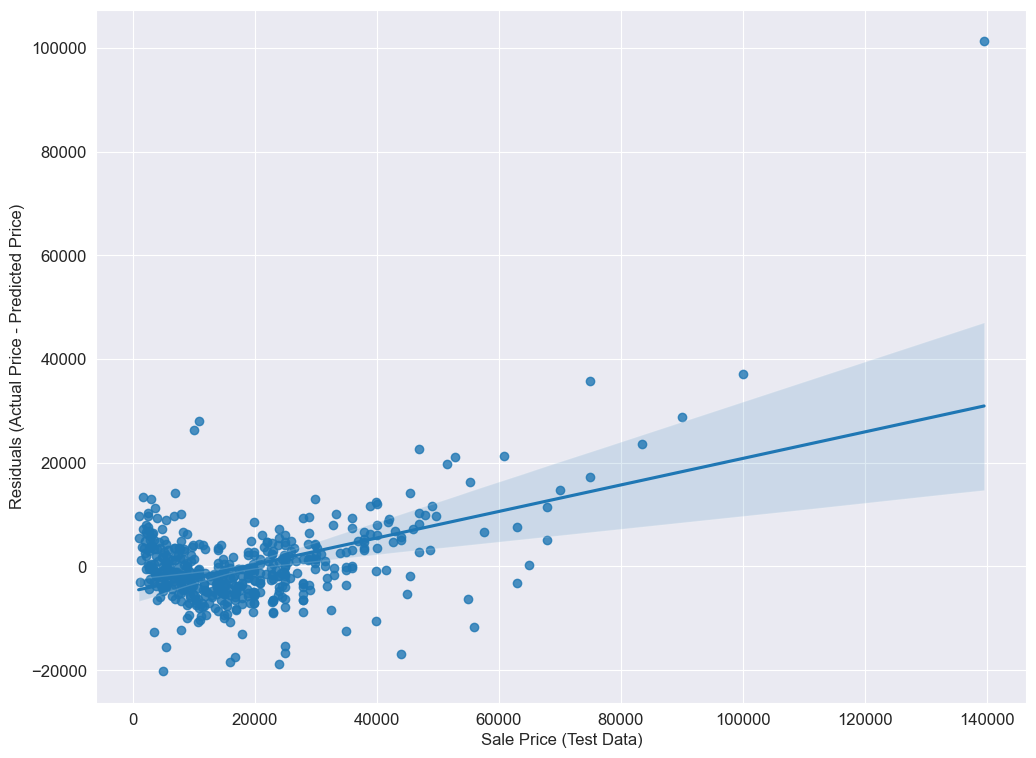

In [26]:
gm1_residuals = y_test - y_pred
ax = sns.regplot(x=y_test, y=gm1_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

The data looks quite homogenous around 0, we do underfit a little at the highest prices but as this region of the data is quite sparse that was to be expected. But generally the model fits well in our opinion. Now let's find out which of our variables in our regression have the highest impact on the price.

In [27]:
price_model = sm.ols(formula="Price ~ Model", data=df).fit()
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     21.76
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:04:02   Log-Likelihood:                -51747.
No. Observations:                4811   AIC:                         1.039e+05
Df Residuals:                    4603   BIC:                         1.053e+05
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.582e+04   3669.794      4.312      0.000    8629.943     2.3e+04
Model[T.107]         -1.227e+04   4318.235     -2.841      0.005   -2.07e+04   -3800.496
Model[T.108]         -6501.6364   4425.939     -1.469      0.142   -1.52e+04    2175.325
Model[T.2]            7736.3571   4458.748      1.735      0.083   -1004.927    1.65e+04
Model[T.200]          9211.6528   3916.358      2.352      0.019    1533.713    1.69e+04
Model[T.2008]        -4703.2391   4395.768     -1.070      0.285   -1.33e+04    3914.574
Model[T.206]         -1.385e+04   4881.283     -2.838      0.005   -2.34e+04   -4280.999
Model[T.207]          -1.24e+04   4220.392     -2.939      0.003   -2.07e+04   -4128.217
Model[T.208]         -4547.1071   4275.181     -1.064      0.288   -1.29e+04    3834.298
Model[T.3-serie]     -3209.0833   4033.993     -0.796      0.426   -1.11e+04    4699.477
Model[T.300]          1.886e+04   4968.925      3.796      0.000    9120.524    2.86e+04
Model[T.308]         -9620.6429   4458.748     -2.158      0.031   -1.84e+04    -879.359
Model[T.330e]         9293.5000   6356.270      1.462      0.144   -3167.838    2.18e+04
Model[T.5-serie]      2414.6935   4220.392      0.572      0.567   -5859.299    1.07e+04
Model[T.500]          -346.2460   3950.326     -0.088      0.930   -8090.778    7398.286
Model[T.500c]        -4592.0000   5504.692     -0.834      0.404   -1.54e+04    6199.835
Model[T.523i]        -8004.5000   6356.270     -1.259      0.208   -2.05e+04    4456.838
Model[T.7-serie]      1.422e+04   5718.961      2.486      0.013    3004.165    2.54e+04
Model[T.80]           4.798e+04   5504.692      8.716      0.000    3.72e+04    5.88e+04
Model[T.90]           4073.1667   5332.088      0.764      0.445   -6380.282    1.45e+04
Model[T.911]          3.993e+04   5718.961      6.982      0.000    2.87e+04    5.11e+04
Model[T.a1]            210.0849   4001.051      0.053      0.958   -7633.893    8054.063
Model[T.a3]           4593.3468   3831.536      1.199      0.231   -2918.301    1.21e+04
Model[T.a4]           2072.3169   3919.720      0.529      0.597   -5612.214    9756.848
Model[T.a5]           7960.6935   4220.392      1.886      0.059    -313.299    1.62e+04
Model[T.a6]           1.008e+04   3968.627      2.539      0.011    2297.766    1.79e+04
Model[T.a7]           1.455e+04   5070.550      2.870      0.004    4610.246    2.45e+04
Model[T.a8]           6547.1667   5332.088      1.228      0.220   -3906.282     1.7e+04
Model[T.agila]       -1.166e+04   6356.270     -1.835      0.067   -2.41e+04     800.438
Model[T.altea]       -1.141e+04   5992.749     -1.904      0.057   -2.32e+04     339.995
Model[T.alto]        -1.154e+04   5332.088     -2.164      0.031    -2.2e+04   -1082.607
Model[T.arona]        5142.7500   5504.692      0.934    

We can see here that model explains around 50% of the variance in the price but let's look at the others.

In [28]:
price_make = sm.ols(formula="Price ~ Make", data=df).fit()
price_make.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     41.18
Date:                Wed, 29 Mar 2023   Prob (F-statistic):          9.02e-278
Time:                        14:04:03   Log-Likelihood:                -52660.
No. Observations:                4811   AIC:                         1.054e+05
Df Residuals:                    4769   BIC:                         1.057e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.296e+04   4593.944      2.820      0.005    3948.860     2.2e+04
Make[T.alfa romeo]  1.877e+04   6696.767      2.803      0.005    5641.134    3.19e+04
Make[T.audi]        1.435e+04   4631.379      3.098      0.002    5268.400    2.34e+04
Make[T.bmw]         1.046e+04   4669.329      2.241      0.025    1310.633    1.96e+04
Make[T.chevrolet]  -9607.6111   1.08e+04     -0.892      0.373   -3.07e+04    1.15e+04
Make[T.chrysler]   -9455.1111   1.45e+04     -0.651      0.515   -3.79e+04     1.9e+04
Make[T.citroen]    -6048.2944   4763.103     -1.270      0.204   -1.54e+04    3289.586
Make[T.citroën]     2659.0162   4955.579      0.537      0.592   -7056.205    1.24e+04
Make[T.dacia]      -6510.1111   1.45e+04     -0.448      0.654    -3.5e+04     2.2e+04
Make[T.daihatsu]   -8755.1111   1.08e+04     -0.813      0.416   -2.99e+04    1.24e+04
Make[T.dodge]       4.066e+04   4982.832      8.160      0.000    3.09e+04    5.04e+04
Make[T.ferrari]     1.454e+04   1.45e+04      1.001      0.317   -1.39e+04     4.3e+04
Make[T.fiat]       -3165.5427   4806.629     -0.659      0.510   -1.26e+04    6257.669
Make[T.ford]        2378.6933   4658.702      0.511      0.610   -6754.512    1.15e+04
Make[T.honda]      -8179.0000   6496.818     -1.259      0.208   -2.09e+04    4557.763
Make[T.hummer]      1.773e+04   8281.851      2.141      0.032    1495.888     3.4e+04
Make[T.hyundai ]    -180.0370   4962.027     -0.036      0.971   -9907.900    9547.826
Make[T.jaguar]      8169.9798   5453.248      1.498      0.134   -2520.903    1.89e+04
Make[T.jeep]        1.462e+04   5032.414      2.906      0.004    4758.257    2.45e+04
Make[T.kia ]       -1938.3734   4921.187     -0.394      0.694   -1.16e+04    7709.424
Make[T.land rover]  2.085e+04   4865.292      4.286      0.000    1.13e+04    3.04e+04
Make[T.lexus]        666.8889   6077.217      0.110      0.913   -1.12e+04    1.26e+04
Make[T.mazda]       3728.2889   6332.315      0.589      0.556   -8685.972    1.61e+04
Make[T.mercedes]    1.589e+04   4659.732      3.410      0.001    6753.352     2.5e+04
Make[T.mini]        2738.9758   4741.381      0.578      0.564   -6556.319     1.2e+04
Make[T.mitsubishi]  1759.8889   5626.410      0.313      0.754   -9270.471    1.28e+04
Make[T.nissan]      3382.0502   4811.100      0.703      0.482   -6049.926    1.28e+04
Make[T.opel]        -901.3111   4682.963     -0.192      0.847   -1.01e+04    8279.459
Make[T.peugeot]    -3178.0423   4676.891     -0.680      0.497   -1.23e+04    5990.823
Make[T.porsche]     3.811e+04   4975.640      7.659      0.000    2.84e+04    4.79e+04
Make[T.ram]         1.388e+04   5136.186      2.703      0.007    3812.566     2.4e+04
Make[T.range]       3.516e+04   9187.889      3.827      0.000    1.71e+04    5.32e+04
Make[T.renault]      407.6140   4655.9

Here we see that Make only explains 26% of the variance This is less than the model so model is more important to tell the price so far.

In [29]:
price_year = sm.ols(formula="Price ~ Year", data=df).fit()
price_year.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     2821.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:04:03   Log-Likelihood:                -52278.
No. Observations:                4811   AIC:                         1.046e+05
Df Residuals:                    4809   BIC:                         1.046e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.752e+06    7.1e+04    -52.849      0.000   -3.89e+06   -3.61e+06
Year        1871.9161     35.243     53.115      0.000    1802.824    1941.009
==============================================================================
Omnibus:                     2627.089   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25051.270
Skew:                           2.450   Prob(JB):                         0.00
Kurtosis:                      13.048   Cond. No.                     7.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here we have that Year explains about 37% of the variance in the price which is better than the Make but still worse than Model so Model is still the best metric so far from our regression.

In [30]:
price_ran = sm.ols(formula="Price ~ Ran", data=df).fit()
price_ran.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     1582.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):          2.54e-299
Time:                        14:04:03   Log-Likelihood:                -52705.
No. Observations:                4811   AIC:                         1.054e+05
Df Residuals:                    4809   BIC:                         1.054e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.182e+04    381.997     83.290      0.000    3.11e+04    3.26e+04
Ran           -0.0958      0.002    -39.772      0.000      -0.101      -0.091
==============================================================================
Omnibus:                     2145.998   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14215.459
Skew:                           2.020   Prob(JB):                         0.00
Kurtosis:                      10.389   Cond. No.                     3.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And as the last variable we have the Ran or mileage of the car we see that about 25% of the variance is explained by the Ran of the car. Therefore the most important variable we found which explains the price of the car best in our regression is the Model of the car.

Now another question we had was which car was the most popular car on the site we will define this as the most listed make + model car on the site. Let's see below which on that is.

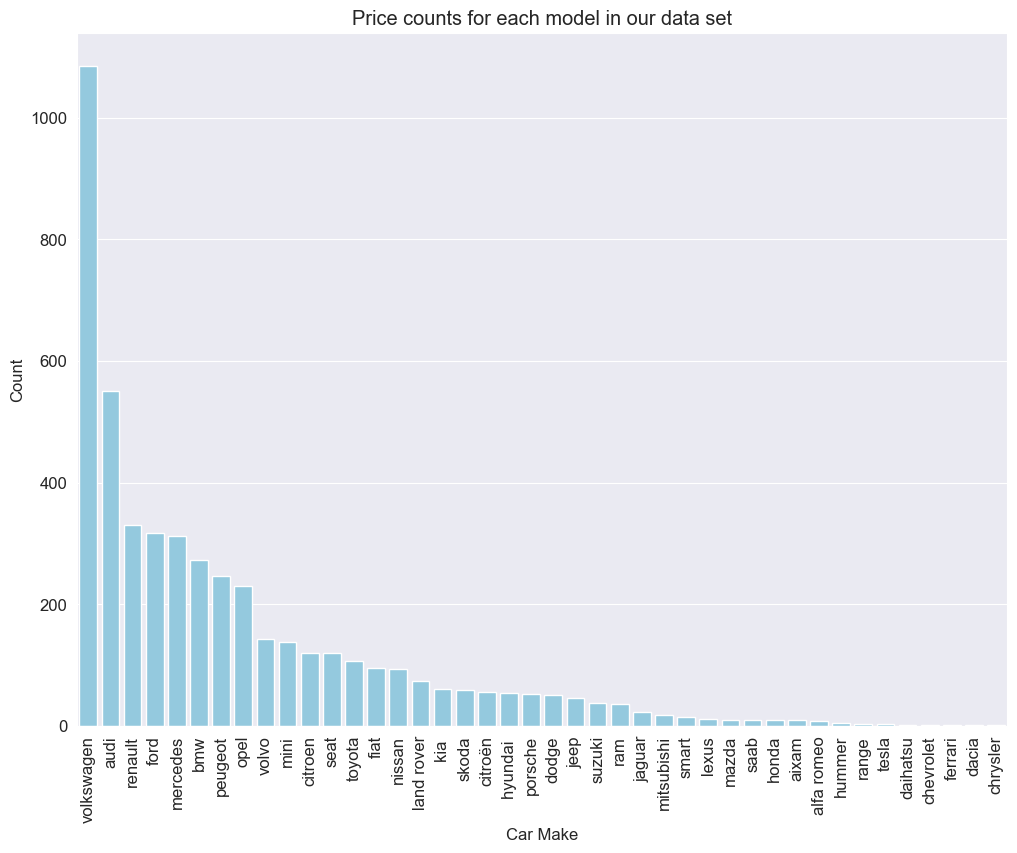

In [31]:
car_counts_make = df.groupby(['Make'])['Make'].count().reset_index(name='Count')
car_counts_make_sorted = car_counts_make.sort_values(by=['Count'], ascending=False)

ax = sns.barplot(x='Make', y='Count', data=car_counts_make_sorted, color='skyblue')
# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Set the plot title and labels
plt.title("Price counts for each model in our data set")
plt.xlabel("Car Make")
plt.ylabel("Count")

# Show the plot
plt.show()




Well in the chart above it is quite clear that volkswagen is the most popular brand by far with more than 1000 volkswagens listed then in second place we have audi with more than 500 cars and then quite a big jump down again to third place which is renault. But let's see if the most popular model is also from volkswagen.

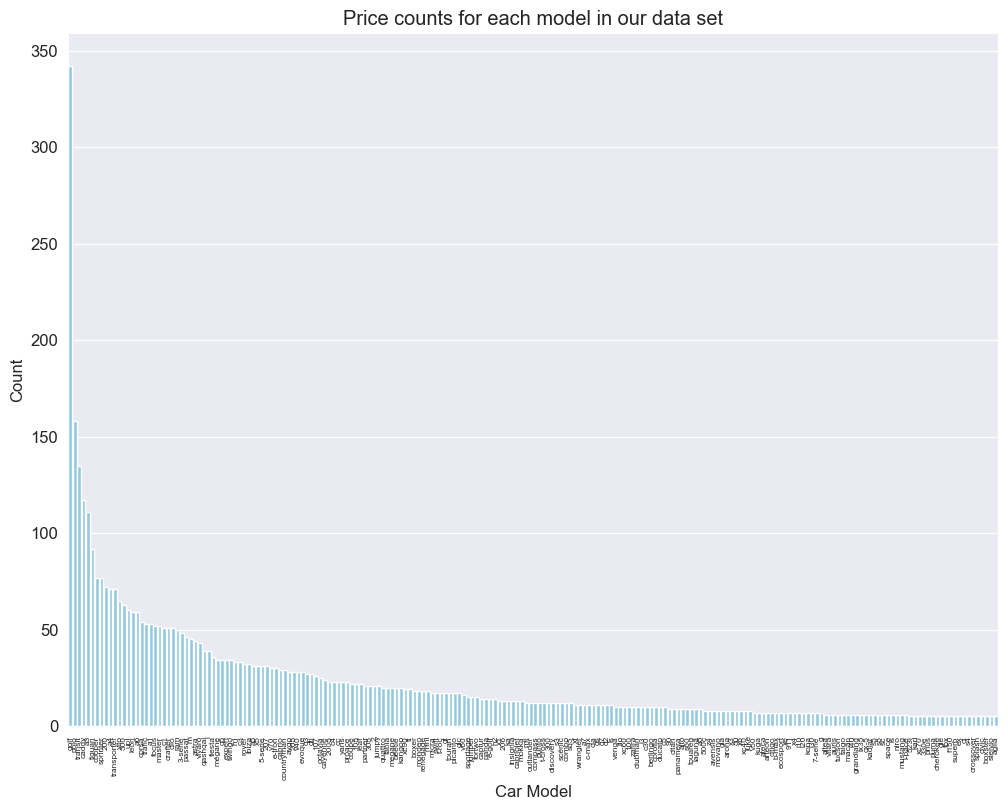

In [32]:
car_counts_model = df.groupby(['Model'])['Model'].count().reset_index(name='Count')
car_counts_model_sorted = car_counts_model.sort_values(by=['Count'], ascending=False)

ax = sns.barplot(x='Model', y='Count', data=car_counts_model_sorted, color='skyblue')
# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.xticks(fontsize=6)

# Set the plot title and labels
plt.title("Price counts for each model in our data set")
plt.xlabel("Car Model")
plt.ylabel("Count")

# Show the plot
plt.show()

It is quite clear that there is one very big winner here but due to the amount of brands we cannot see the name of the winning Model so let's make another plot where we cutoff the brand with a from a specific count.

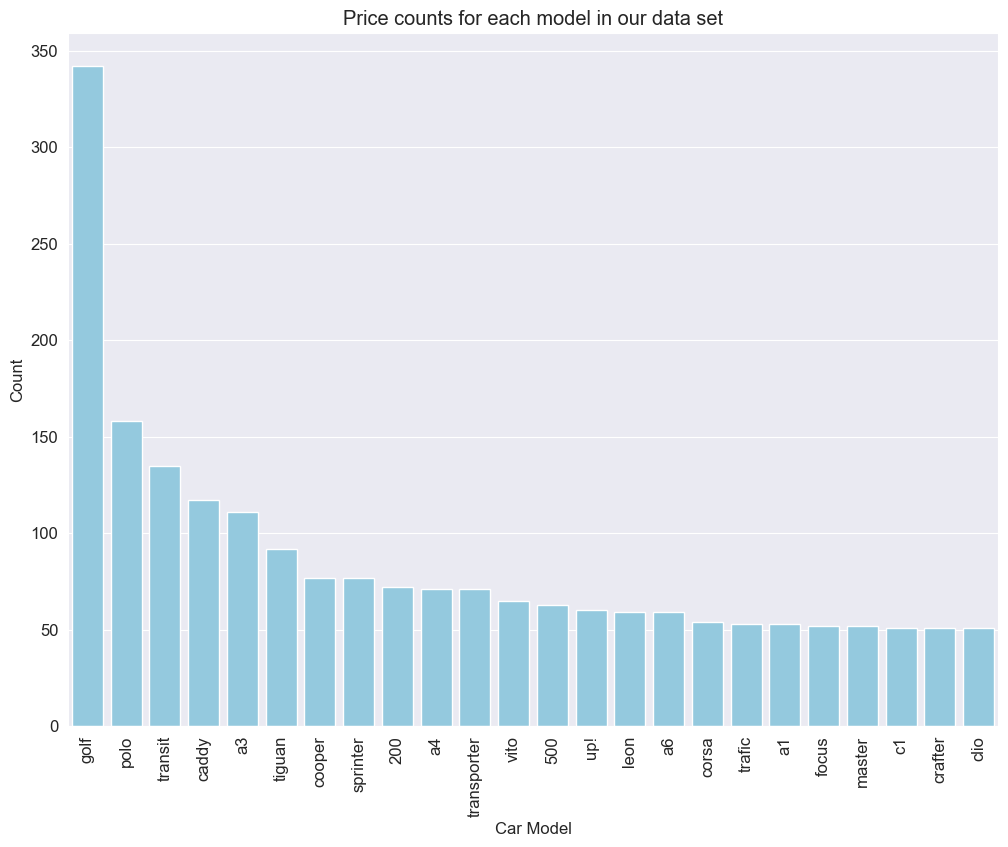

In [33]:
car_counts_model = df.groupby(['Model'])['Model'].count().reset_index(name='Count')
car_counts_model_sorted = car_counts_model.sort_values(by=['Count'], ascending=False)
car_counts_model_sorted = car_counts_model_sorted[(car_counts_model_sorted["Count"] > 50)] 

ax = sns.barplot(x='Model', y='Count', data=car_counts_model_sorted, color='skyblue')
# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.xticks(fontsize=12)

# Set the plot title and labels
plt.title("Price counts for each model in our data set")
plt.xlabel("Car Model")
plt.ylabel("Count")

# Show the plot
plt.show()

In [34]:
car_counts = df.groupby(['Model', 'Make'])['Model'].count().reset_index(name='Count')
car_counts_sorted = car_counts.sort_values(by=['Count'], ascending=False)
car_counts_sorted = car_counts_sorted.reset_index(drop=True)
car_counts_sorted.head()

,Model,Make,Count
0,golf,volkswagen,340
1,polo,volkswagen,156
2,transit,ford,135
3,caddy,volkswagen,115
4,a3,audi,111


And as we see from the plot and table above, the most popular car model in the dataset is the Volkswagen Golf, with a total of 340 counts. Three out of the top five models are from Volkswagen, with the Polo being the second most popular model with 156 counts, closely followed by the Transit from Ford with 135 counts. Therefore, Volkswagen wins the title for the most popular car model in the dataset with the Golf being more than twice as popular as the second most popular model."

Ethical analysis:

While scraping the data from marktplaats.nl, we got denied access after about 50 requests. As a consequence of this, we were limited by the amount of listings we could scrape per day. This is likely implemented by marktplaats on purpose to either protect from potential DDOS attacks, or perhaps even to prevent people from scraping their data.

Why would marktplaats not want their data scraped? Most listings are made by actual people, and to list something, you must be logged in. If you were to scrape one persons listings, and keep track of those, you could learn things about that person, especially since people have their town linked too. Realistically, this is not a big issue, as one could also just look at someones profile and look at their listings. Also, in this implementation, the scraped data is shared with no one, and the data is not used in a harmful way. We do scrape the sellers name, but this was only used to filter out companies. It could be deleted now, and would likely be smart, when looking at the ethical side of things.

The second ethical consideration is part of the regression model. If we were to deploy the model and have people use it to hint them toward the price they should sell their car for, would the developers be held accountable for inaccurate predictions? Of course, the model could underprice someone's vehicle, and if they were reckless and would not research the price further, they could lose a large amount of money.

If a deployment were to be made, clear terms and conditions would need to be specified, and it should be made clear to the user that the price is merely an indication.

Welcome to the end of our data madness journey I hope our notebook was insightful to the cars and their price on marktplaats, and we hope you enjoyed reading our analysis because we enjoyed working on it :).